In [1]:
from langgraph.graph import StateGraph, START, END
from langchain_openai import ChatOpenAI
from typing import TypedDict
from IPython.display import Image
from dotenv import load_dotenv
import os

load_dotenv()
model = ChatOpenAI(model=os.getenv("gpt_model"))

In [2]:
class FitnessState(TypedDict):
    gender: str
    age: int
    weight_kg: float
    height_cm: float
    goal: str
    aboutyou: str
    dietpreference: str

    bmi: float
    fitnesslevel: str
    plan: str

In [3]:
def calcuate_bmi(state: FitnessState) -> FitnessState:
    weight = state['weight_kg']
    height = state['height_cm']/100
    bmi = weight/(height**2)
    state['bmi'] = round(bmi,2)

    return state

def get_fitnesslevel(state: FitnessState) -> FitnessState:
    # fetch basic details
    gender = state['gender']
    bmi = state['bmi']
    age = state['age']
    aboutyou = state['aboutyou']
    title = "his" if gender.lower()=="male" else "her"
 
    # call llm gen fitness level
    fitnesslevel_prompt = f"""
    you are a professional fitness coach
    a {age} year old {gender} has a BMI of {bmi}.
    here is how they describe themselves:
    {aboutyou}

    write a short assesssment of {title} fitness level (strength, cardio, fat, mobility)
    """
    content = model.invoke(fitnesslevel_prompt).content

    # update the answer in the state
    state['fitnesslevel'] = content

    return state

def get_workoutplan(state: FitnessState) -> FitnessState:
    # fetch title
    gender = state['gender']
    bmi = state['bmi']
    age = state['age']
    goal = state['goal']
    fitnesslevel = state['fitnesslevel']
    dietpreference = state['dietpreference']
    # call llm gen outline
    workoutlevel_prompt = f"""
    you are a certified fitness trainer.
    client profile:- 
    Age: {age}
    Gender: {gender}
    BMI: {bmi}
    Goal: {goal}
    Diet Preference: {dietpreference}

    Fitness assessment:
    {fitnesslevel}

    create a 7-day workout plan with 
    - strength
    - cardio
    - rest
    - intensity guidance
    - diet
    """
    content = model.invoke(workoutlevel_prompt).content

    # update the answer in the state
    state['plan'] = content

    return state

In [4]:
# create a graph

graph = StateGraph(FitnessState)

# add nodes
graph.add_node('calcuate_bmi',calcuate_bmi)
graph.add_node('get_fitnesslevel',get_fitnesslevel)
graph.add_node('get_workoutplan',get_workoutplan)
# add edges
graph.add_edge(START,'calcuate_bmi')
graph.add_edge('calcuate_bmi','get_fitnesslevel')
graph.add_edge('get_fitnesslevel','get_workoutplan')
graph.add_edge('get_workoutplan',END)

# comple
workflow = graph.compile()

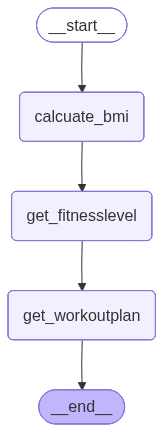

In [5]:
Image(workflow.get_graph().draw_mermaid_png())

In [6]:
# execute
initial_state = {
    'gender':'Male'
    , 'age':29
    , 'weight_kg':72
    , 'height_cm': 171
    , 'goal': 'Muscel gain'
    , 'aboutyou': 'i am a corporate employee with active lifestyle and i go to the gym 4-5 days a week. i am regular to the fitness and i am consistent to GYM from several years now'
    , 'dietpreference': 'veg'
    }
reponse_state = workflow.invoke(initial_state)

In [7]:
print(reponse_state['plan'])

Sure! Below is a 7-day workout plan tailored to your profile, focusing on muscle gain while considering your vegetarian diet preference.

### 7-Day Workout Plan:

#### **Day 1: Strength Training (Upper Body Focus)**
   - **Warm-Up:** 5-10 minutes of dynamic stretching or light cardio (jogging, rope skipping)
   - **Workout:**
     - Bench Press: 4 sets of 8-10 reps
     - Dumbbell Rows: 4 sets of 8-10 reps (each side)
     - Shoulder Press: 3 sets of 10-12 reps
     - Pull-Ups/Assisted Pull-Ups: 3 sets of 5-8 reps
     - Dumbbell Bicep Curls: 3 sets of 10-12 reps
     - Tricep Dips: 3 sets of 8-10 reps
   - **Cool Down:** Stretching focusing on upper body
   - **Intensity:** Moderate to high (last 2 reps should be challenging)

#### **Day 2: Cardio + Mobility**
   - **Warm-Up:** 5 minutes of light jogging
   - **Workout:**
     - 30-45 minutes of HIIT (e.g., sprint for 30 seconds followed by 1 minute of walking, repeat)
   - **Mobility Work:** 15-20 minutes of yoga or targeted stretchi

In [8]:
reponse_state.keys()

dict_keys(['gender', 'age', 'weight_kg', 'height_cm', 'goal', 'aboutyou', 'dietpreference', 'bmi', 'fitnesslevel', 'plan'])

In [11]:
reponse_state['bmi']

24.62

In [10]:
print(reponse_state['fitnesslevel'])

Based on the information provided, here’s an assessment of your fitness level:

### Strength:
Given your consistent gym attendance of 4-5 days a week over several years, it is likely that your strength is well-developed, especially if you incorporate a mix of resistance training in your routine. A BMI of 24.62 suggests a healthy body composition, which typically indicates a balance between muscle mass and body fat. To further assess your strength, consider evaluating your performance in compound lifts (e.g., squats, deadlifts, bench press), as well as your ability to perform bodyweight exercises (e.g., push-ups, pull-ups).

### Cardio:
An active lifestyle along with regular gym visits likely correlates with good cardiovascular fitness. If you are engaging in heart-rate-raising workouts such as running, cycling, or high-intensity interval training (HIIT), you likely have a strong cardiovascular foundation. To gauge your cardio fitness, you might want to consider a timed mile run or a VO